In [1]:
import keras
from keras.applications.vgg16 import VGG16, decode_predictions
import keras.backend as K

import tensorflow as tf

from fi_utils import *

import numpy as np
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
model = VGG16()

Instructions for updating:
Colocations handled automatically by placer.


## Build Generator

Because for skin cancer we want to work mostly with textures rather than structure, we will invert the features from much earlier layers.

In [3]:
from keras.models import Model
from keras.layers import Lambda, Reshape

In [4]:
# Leaky Relu
lrelu = lambda x: tf.keras.activations.relu(x, alpha=0.1)

In [5]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [6]:
m_input = model.get_input_at(0)

# Features to Invert
bottom  = model.get_layer("block3_conv3").output

# Inversions begin
bottom_conv1 = keras.layers.Conv2D(256, (3, 3), padding="same", activation=lrelu, name="Invert_1")(bottom)
bottom_conv2 = keras.layers.Conv2D(256, (3, 3), padding="same", activation=lrelu, name="Invert_2")(bottom_conv1)

up1 = keras.layers.Conv2DTranspose(128, (3, 3), strides=(2, 2), padding="same", activation=lrelu, name="Invert_3")(bottom_conv2)
conv1 = keras.layers.Conv2D(128, (3, 3), padding="same", activation=lrelu, name="Invert_4")(up1)

up2 = keras.layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), padding="same", activation=lrelu, name="Invert_5")(conv1)
conv2 = keras.layers.Conv2D(64, (3, 3), padding="same", activation=lrelu, name="Invert_6")(up2)

m_output = keras.layers.Conv2D(3, (3, 3), padding="same", activation="linear", name="Regression")(conv2)
inverse = Model(inputs=[m_input], outputs=[m_output])

inverse.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [7]:
for i, layer in enumerate(inverse.layers):
    if i <= 9:
        layer.trainable = False
    else:
        layer.trainable = True
        
    print(i, layer.name, layer.trainable)

0 input_1 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 Invert_1 True
11 Invert_2 True
12 Invert_3 True
13 Invert_4 True
14 Invert_5 True
15 Invert_6 True
16 Regression True


In [8]:
def clipped_mse(y_true, y_pred):
    return K.mean(K.square(K.clip(y_pred, -127, 127) - y_true), axis=-1)

In [9]:
inverse.compile(optimizer=keras.optimizers.Adam(lr=0.001), loss=clipped_mse)

### Organise training data

In [10]:
# TRAINING
cat_path = "/home/simon/Desktop/Cat_Dog/training_set/cats"
dog_path = "/home/simon/Desktop/Cat_Dog/training_set/dogs"

files = [ os.path.join(cat_path, file) for file in os.listdir(cat_path)]
files.extend([ os.path.join(dog_path, file) for file in os.listdir(dog_path)])

# Clean files
files = [ file for file in files if ".jpg" in file]

# VALIDATION
cat_test_path = "/home/simon/Desktop/Cat_Dog/test_set/cats"
dog_test_path = "/home/simon/Desktop/Cat_Dog/test_set/dogs"

test_files = [ os.path.join(cat_test_path, file) for file in os.listdir(cat_test_path)]
test_files.extend([ os.path.join(dog_test_path, file) for file in os.listdir(dog_test_path)])

# Clearn files
test_files = [ file for file in test_files if ".jpg" in file]

In [11]:
test_gen = Generator(test_files, batch_size=32)
train_gen = Generator(files, batch_size=32)

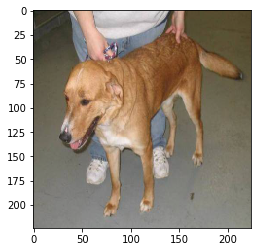

In [13]:
X, y = next(train_gen)
plt.imshow(deprocess_image(X[0].copy()));

## Train on data

In [14]:
history = inverse.fit_generator(train_gen,
                                epochs=500,
                                verbose=True,
                                steps_per_epoch=train_gen.n // train_gen.batch_size,
                                validation_data=test_gen,
                                validation_steps=(test_gen.n // test_gen.batch_size) // 2,
                               )

Instructions for updating:
Use tf.cast instead.
Epoch 1/500
250/250 [==============================] - 167s 666ms/step - loss: 861.3759 - val_loss: 306.2395
Epoch 2/500
250/250 [==============================] - 161s 644ms/step - loss: 275.6158 - val_loss: 250.5365
Epoch 3/500
250/250 [==============================] - 150s 599ms/step - loss: 242.1619 - val_loss: 218.3551
Epoch 4/500
250/250 [==============================] - 150s 601ms/step - loss: 207.4406 - val_loss: 205.9485
Epoch 5/500
250/250 [==============================] - 150s 600ms/step - loss: 195.4401 - val_loss: 191.8747
Epoch 6/500
250/250 [==============================] - 149s 598ms/step - loss: 186.1414 - val_loss: 178.2295
Epoch 7/500
250/250 [==============================] - 149s 595ms/step - loss: 175.7287 - val_loss: 178.3996
Epoch 8/500
250/250 [==============================] - 149s 598ms/step - loss: 171.2380 - val_loss: 164.6573
Epoch 9/500
250/250 [==============================] - 152s 609ms/step - loss: 1

KeyboardInterrupt: 

In [16]:
inverse.save_weights("./weights/inverse_block3_conv3_val_loss_174.h5")

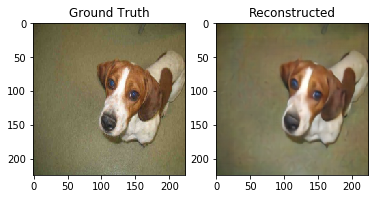

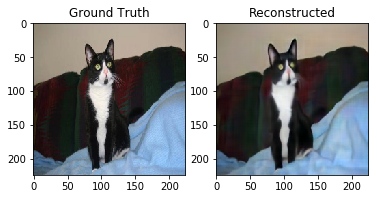

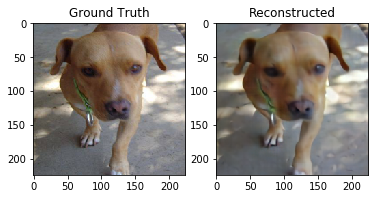

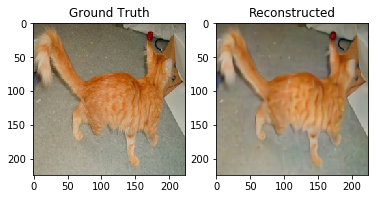

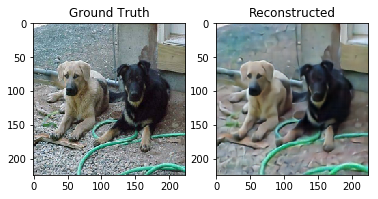

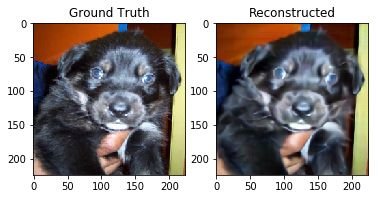

In [18]:
X, _ = next(test_gen)

for i in range(6):
    
    pred = inverse.predict(X[i][np.newaxis, ::])
    fig, axes = plt.subplots(1, 2)
    axes[0].set_title("Ground Truth")
    axes[0].imshow(deprocess_image(X[i]))
    
    axes[1].set_title("Reconstructed")
    axes[1].imshow(deprocess_image(pred[0]))

    plt.show()

## Optimisation

In [19]:
inverse.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [139]:
# Create generator
code_tensor = K.variable(np.random.random((1, 56, 56, 256)))
x = inverse.get_layer("Invert_1")(code_tensor)
x = inverse.get_layer("Invert_2")(x)
x = inverse.get_layer("Invert_3")(x)
x = inverse.get_layer("Invert_4")(x)
x = inverse.get_layer("Invert_5")(x)
x = inverse.get_layer("Invert_6")(x)
# Get generated image
gen_img = inverse.get_layer("Regression")(x)
# Feed into original classifier
gen_out = model(gen_img)

In [140]:
#loss = K.mean(gen_out.op.inputs[0][:, 207]) # Goldren Retriever
#loss = K.mean(gen_out.op.inputs[0][:, 951]) # lemon
#loss = K.mean(gen_out.op.inputs[0][:, 889]) # violin
#loss = K.mean(gen_out.op.inputs[0][:, 983]) # Scuba diver 
#loss = K.mean(gen_out.op.inputs[0][:, 949]) # Strawberry
#loss = K.mean(gen_out.op.inputs[0][:, 920]) # traffic light
#loss = K.mean(gen_out.op.inputs[0][:, 779]) # school bus
#loss = K.mean(gen_out.op.inputs[0][:, 1]) # gold fish
#loss = K.mean(gen_out.op.inputs[0][:, 100]) # black swan
#loss = K.mean(gen_out.op.inputs[0][:, 232]) # border collie
#loss = K.mean(gen_out.op.inputs[0][:, 386]) # African Elephant
#loss = K.mean(gen_out.op.inputs[0][:, 130]) # flamingo
#loss = K.mean(gen_out.op.inputs[0][:, 302])  # ground beetle
#loss = K.mean(gen_out.op.inputs[0][:, 77]) # wolf spider
#loss = K.mean(gen_out.op.inputs[0][:, 22]) # bald eagle
#loss = K.mean(gen_out.op.inputs[0][:, 2]) # great white shark
#loss = K.mean(gen_out.op.inputs[0][:, 31]) # tree frog
#loss = K.mean(gen_out.op.inputs[0][:, 20]) # water ouzel
#loss = K.mean(gen_out.op.inputs[0][:, 488]) # chain 488
#loss = K.mean(gen_out.op.inputs[0][:, 780]) # schooner 780
loss = K.mean(gen_out.op.inputs[0][:, 821]) # suspension bridge
loss *= -1

Step 0 Current loss value: 1.5541967


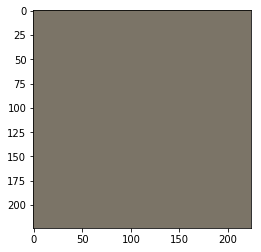

Step 100 Current loss value: -15.916466


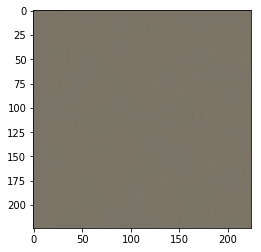

Step 200 Current loss value: -18.695545


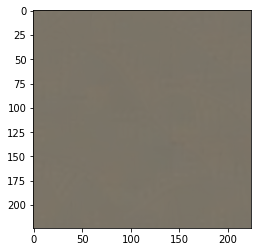

Step 300 Current loss value: -21.722275


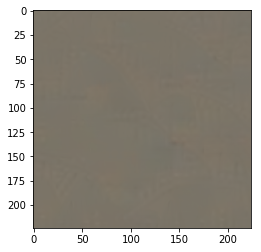

Step 400 Current loss value: -25.365007


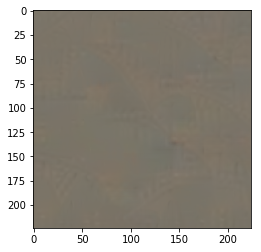

Step 500 Current loss value: -29.75305


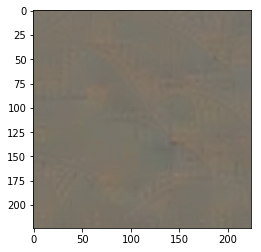

Step 600 Current loss value: -34.856045


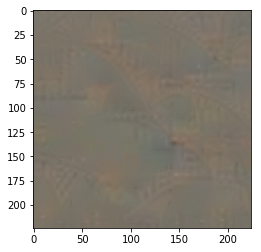

Step 700 Current loss value: -40.638714


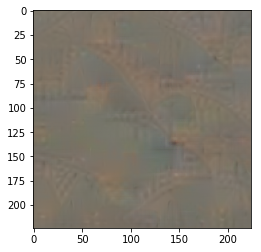

Step 800 Current loss value: -46.989048


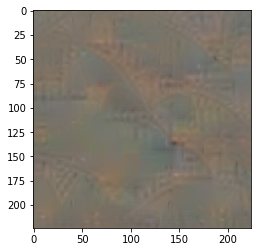

Step 900 Current loss value: -53.810947


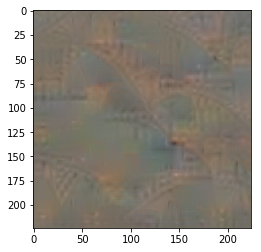

Step 1000 Current loss value: -61.08501


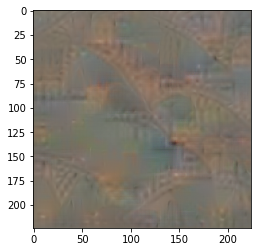

Step 1100 Current loss value: -68.793884


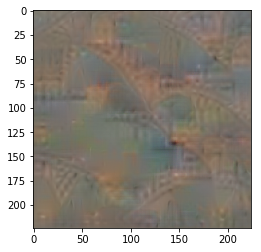

Step 1200 Current loss value: -76.885826


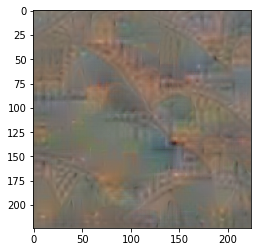

Step 1300 Current loss value: -85.2827


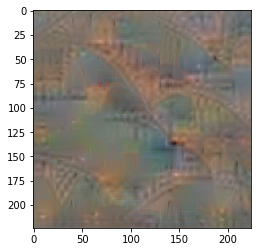

Step 1400 Current loss value: -93.93072


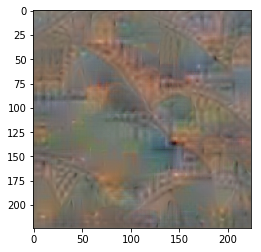

Step 1500 Current loss value: -102.82454


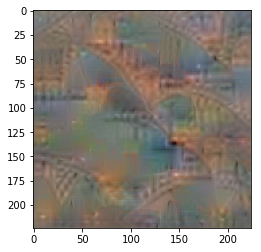

Step 1600 Current loss value: -111.945755


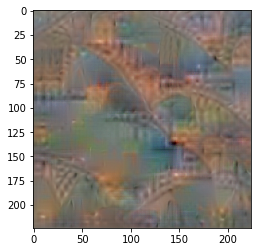

Step 1700 Current loss value: -121.28959


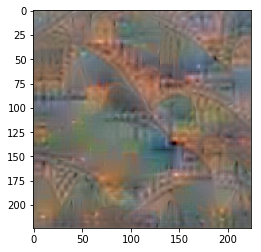

Step 1800 Current loss value: -130.85258


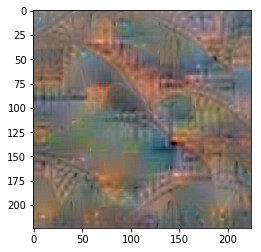

Step 1900 Current loss value: -140.61308


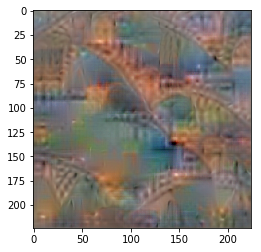

Step 2000 Current loss value: -150.5526


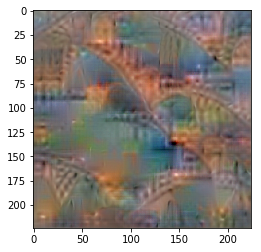

Step 2100 Current loss value: -160.63036


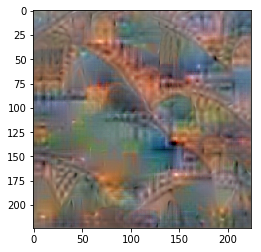

Step 2200 Current loss value: -170.8639


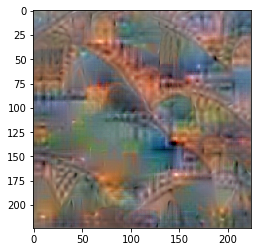

Step 2300 Current loss value: -181.23807


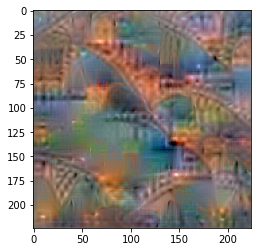

Step 2400 Current loss value: -191.72198


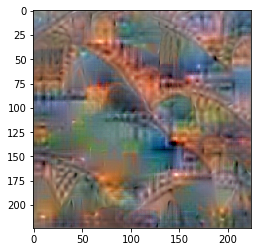

Step 2500 Current loss value: -202.31308


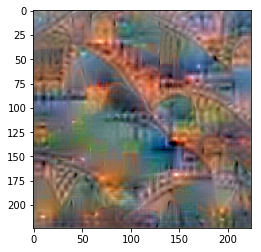

Step 2600 Current loss value: -213.00041


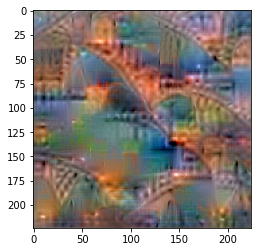

Step 2700 Current loss value: -223.77124


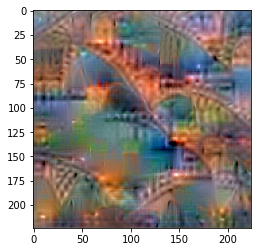

Step 2800 Current loss value: -234.612


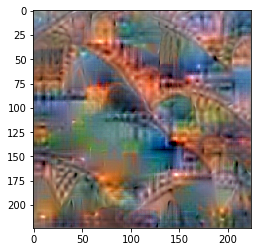

Step 2900 Current loss value: -245.53352


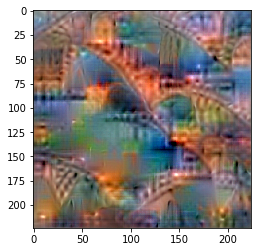

In [141]:
# Create optimizer
optimiser = tf.train.AdamOptimizer(learning_rate=0.05).minimize(loss, var_list=[code_tensor])

# Using the current Keras session
sess = K.get_session()

# Optimise the input
for i in range(3000):

    # Update compute loss, get gradients & update image
    loss_value, _, code, raw_img = sess.run([loss, optimiser, code_tensor, gen_img])
    
    if i % 100 == 0:
        print("Step", i, 'Current loss value:', loss_value)
        # Show current generated image
        plt.imshow(deprocess_image(raw_img[0]))
        plt.show()
        
final_img = K.eval(gen_img)
imsave("./images/suspension_bridge_block3_conv3.png", deprocess_image(final_img[0]))

## Optimise individual filters

In [236]:
model_tensors = {}
# Create generator
code_tensor = K.variable(np.random.random((1, 56, 56, 256)))
x = inverse.get_layer("Invert_1")(code_tensor)
x = inverse.get_layer("Invert_2")(x)
x = inverse.get_layer("Invert_3")(x)
x = inverse.get_layer("Invert_4")(x)
x = inverse.get_layer("Invert_5")(x)
x = inverse.get_layer("Invert_6")(x)
# Get generated image
gen_img = inverse.get_layer("Regression")(x)

# Feed into original classifier
x = gen_img
for layer in model.layers[1::]:
    if layer.name == "block4_pool":
        gen_out = layer(x).op.inputs[0]
        break
    else:
        x = layer(x)

In [239]:
# loss = K.mean(gen_out[:, :, :, 56]) * 0.5
# loss += K.mean(gen_out[:, :, :, 412]) * 0.5
# loss += K.mean(gen_out[:, :, :, 191]) * 1
# loss += K.mean(gen_out[:, :, :, 40]) * 0.6
# loss += K.mean(gen_out[:, :, :, 372]) * 0.5
loss = K.mean(gen_out[:, :, :, 149])
loss *= -1

Step 0 Current loss value: -3.180072


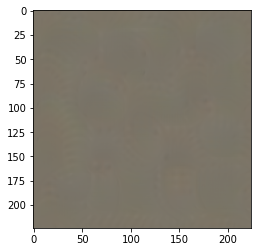

Step 100 Current loss value: -57.96252


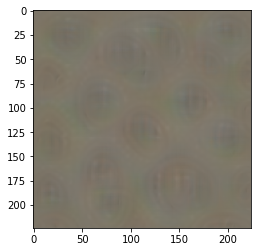

Step 200 Current loss value: -113.330376


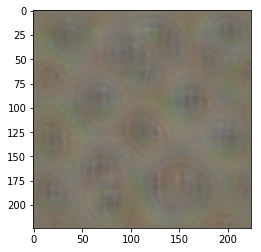

Step 300 Current loss value: -173.8036


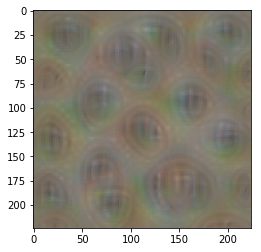

Step 400 Current loss value: -236.10428


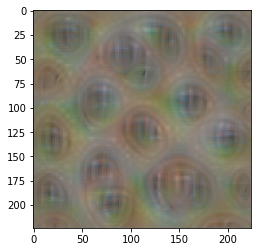

Step 500 Current loss value: -299.87122


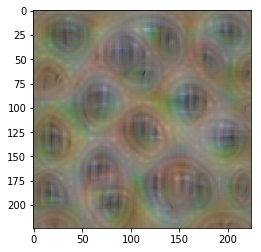

Step 600 Current loss value: -364.38065


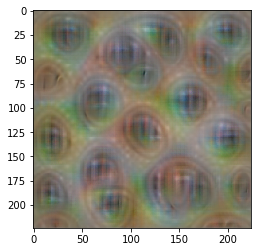

Step 700 Current loss value: -429.56326


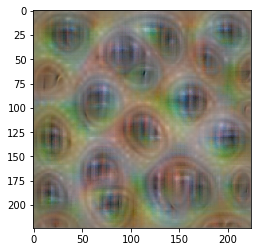

Step 800 Current loss value: -495.1415


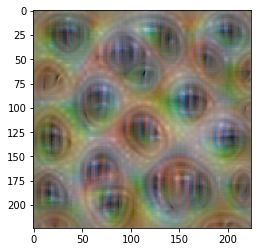

Step 900 Current loss value: -560.89044


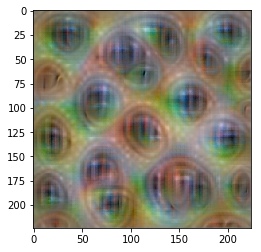

Step 1000 Current loss value: -626.8407


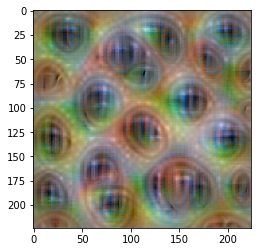

Step 1100 Current loss value: -692.92975


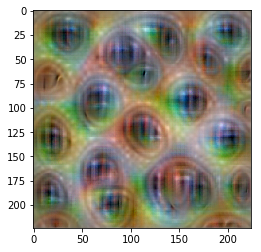

Step 1200 Current loss value: -759.15295


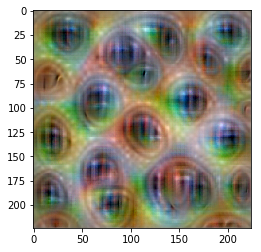

Step 1300 Current loss value: -825.46826


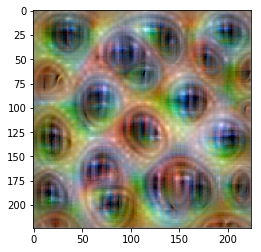

Step 1400 Current loss value: -891.79926


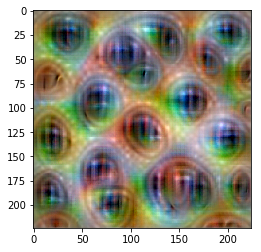

Step 1500 Current loss value: -958.20166


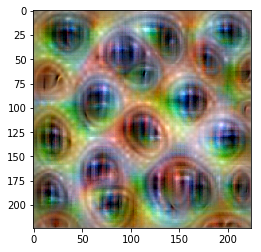

Step 1600 Current loss value: -1024.7615


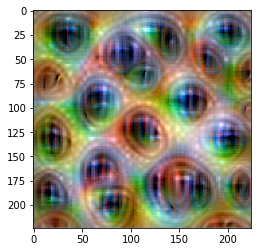

Step 1700 Current loss value: -1091.3783


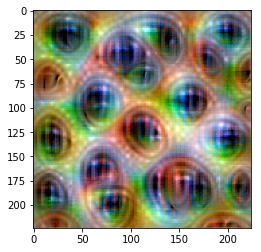

Step 1800 Current loss value: -1157.9379


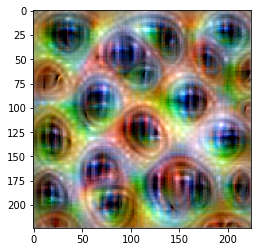

Step 1900 Current loss value: -1224.445


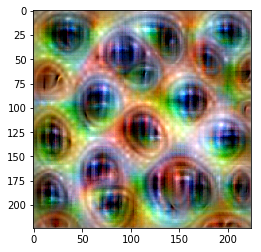

In [240]:
# Create optimizer
optimiser = tf.train.AdamOptimizer(learning_rate=0.05).minimize(loss, var_list=[code_tensor])

# Using the current Keras session
sess = K.get_session()

# Optimise the input - intialise for whole layer to begin with, and then pick a filter
for i in range(2000):

    # Update compute loss, get gradients & update image
    loss_value, _, code, raw_img = sess.run([loss, optimiser, code_tensor, gen_img])
    
    if i % 100 == 0:
        print("Step", i, 'Current loss value:', loss_value)
        # Show current generated image
        plt.imshow(deprocess_image(raw_img[0]))
        plt.show()

In [241]:
final_img = K.eval(gen_img)
imsave("./block4_pool_149.png".format(0, 6), deprocess_image(final_img[0]))